In [59]:
import pandas as pd
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### Implementation of a Stochastic Volatility Model
#### Based on Yu Meng (2009): Bayesian Analysis of a Stochastic Volatility Model
#### Using the following features:
- Gibbs Sampling
- Metropolis-Hastings algorithm

# Step 1: Setting up data
In this first step we initialize the parameters of the model, namely the time, mean and volatility of the time series.
We also need to initialize the hyperparameters which are the parameters of the distribution of each parameter in the simulation.
We then simulate the time serie of price returns according to the parameters initialized earlier.

### Parameters initialization

In [126]:
T = 200
rho = 0.95
sigma = 0.1
mu = 0.8

### Hyperparameters initialization

In [61]:
alpha_mu = 0
beta_mu = 100
alpha_sigma = 2.5
beta_sigma = 0.025
alpha_rho = 0
beta_rho = 1

### Y Simulation

In [162]:
sim_df = pd.DataFrame()
sim_df['time'] = list(range(0,T+1))
sim_df['y'] = np.random.normal(0,1,T+1)
sim_df['x'] = mu + np.random.normal(0,1,T+1)*sigma
sim_df['eps'] = np.random.normal(0,1,T+1)*sigma

sim_df['x_lag'] = sim_df['x'].shift(-1)
sim_df['x'] = mu*(1-rho) + sim_df['x_lag']*rho + sim_df['eps']
sim_df['y']=np.exp(sim_df['x']/2)*sim_df['y']
sim_df = sim_df.drop(200)
T= 199

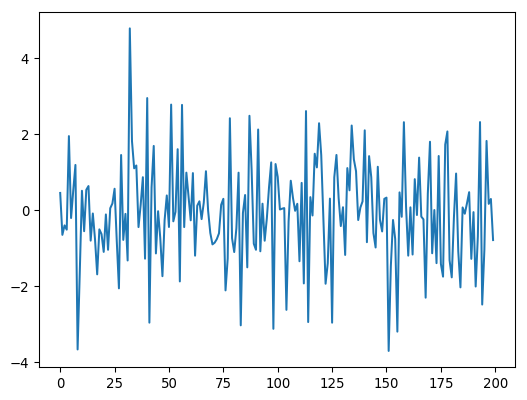

In [63]:
#dots = sns.load_dataset("dots").query("align == 'dots'")
#ax = sns.lineplot(x='time', y='y',data=sim_df)

ax = plt.plot(sim_df['time'], sim_df['y'])

### Sigma Simulation

In [114]:
def sim_sigma(alpha, beta, x, mu, rho, T):
    s = 0
    for t in range(T):
        s = s + np.power(x[t] - mu - rho * (x[t] - mu), 2) + np.power(x[0] - mu, 2) * (1 - np.power(rho, 2))

    new_alpha = alpha + (T + 1) / 2.0
    new_beta = beta + 0.5 * s
    res = sp.stats.invgamma.rvs(new_alpha, scale=new_beta)

    return {'sim': res, 'alpha': new_alpha, 'beta': new_beta}


### Rho Simulation

In [115]:
def sim_rho(alpha, beta, x, mu, sigma):
    sum1 = 0
    for t in range(T):
        sum1 = sum1 + (x[t + 1] - mu) * (x[t] - mu)

    sum2 = 0

    for t in range(T):
        sum2 = sum2 + np.power(x[t] - mu, 2) - np.power(x[0] - mu, 2)

    new_beta = np.power((sum2 / np.power(sigma, 2)) + (1 / np.power(beta, 2)), -1 / 2)
    new_alpha = (np.power(new_beta, 2)) * ((sum1 / np.power(sigma, 2)) + (alpha / np.power(beta, 2)))

    res = sp.stats.truncnorm.rvs(-1, 1, loc=new_alpha, scale=new_beta)

    return {'sim': res, 'alpha': new_alpha, 'beta': new_beta}

### Mu Simulation

In [163]:
def sim_mu(alpha, beta, x, rho, sigma):
    sum = 0
    for t in range(T):
        sum = sum + (x[t + 1] - rho * mu * x[t])

    new_beta = np.power(np.power(1 - rho, 2) + T * (np.power(1 - rho, 2) / np.power(sigma, 2)) + (1 / np.power(beta, 2)), -1 / 2)
    new_alpha = np.power(new_beta, 2) * (x[0] * ((((1 - np.power(rho, 2)) + (1 - rho) * sum) / np.power(sigma, 2)) + (alpha / np.power(beta, 2))))

    res = new_alpha + sp.stats.norm.rvs(1) * new_beta


### Metropolis-Hastings Algorithm
#### Metropolis

In [117]:
def target(xt, alpha_etoile, beta_carre):
    val = -0.5 * (np.log(2 * np.pi) + np.log(beta_carre) + (np.power(xt - alpha_etoile, 2)) / beta_carre)
    return val


def metropolis(target, T, x, sigma, mu, rho, y):
    uniforms = sp.stats.uniform.rvs(size=T + 1)
    samples = np.zeros((T + 1))
    samples[0] = mu + sp.stats.norm.rvs(1) * sigma
    epsilon = sp.stats.norm.rvs(size=T + 1) * sigma
    nbaccepts = 0

    alpha = np.zeros((T + 1))
    alpha_etoile = np.zeros((T + 1))
    beta_carre = np.power(sigma, 2) / (1 + np.power(rho, 2))
    alpha[0] = mu + rho * ((x[0] - mu)) / (1 + np.power(rho, 2))
    alpha_etoile[0] = alpha[0] + 0.5 * beta_carre * ((np.power(y[0], 2)) * np.exp(-alpha[0]) - 1)
    alpha[T] = mu + rho * ((x[T - 1] - mu)) / (1 + np.power(rho, 2))
    alpha_etoile[T] = alpha[T] + 0.5 * beta_carre * (np.power(y[T], 2) * np.exp(-alpha[T]) - 1)

    currentomega = target(samples[0], alpha_etoile[0], beta_carre)

    for t in range(1, T):
        alpha[t] = mu + rho * ((x[t - 1] - mu) + (x[t + 1] - mu)) / (1 + np.power(rho, 2))
        alpha_etoile[t] = alpha[t] + 0.5 * beta_carre * ((np.power(y[t], 2)) * np.exp(-alpha[t]) - 1)

    for t in range(1, T):
        proposal = mu * (1 - rho) + samples[t - 1] * rho + epsilon[t]
        proposalomega = target(proposal, alpha_etoile[t - 1], beta_carre)

        if (np.log(uniforms[t - 1]) < (proposalomega - currentomega)):
            nbaccepts = nbaccepts + 1
            currentomega = proposalomega
            samples[t] = proposal
        else:
            samples[t] = samples[t - 1]
    acceptrate = 100 * nbaccepts / (T + 1)
    return {'sim': samples, 'acceptrate': acceptrate}


#### Gibbs Sampler

In [118]:
def GibbsSampler(T, mu, rho, sigma, x_init, N, y):

    alpha_mu = 0
    beta_mu = 100
    alpha_sigma = 2.5
    beta_sigma = 0.025
    alpha_rho = 0
    beta_rho = 1

    param = np.zeros((N, 3))
    x = x_init
    for k in range(N):
        x[0] = mu + sp.stats.norm.rvs(1) * sigma
        for t in range(1, T):
            val = metropolis(target, T, x, sigma, mu, rho, y)
            x[t] = val['sim'][t]

        val_sigma = sim_sigma(alpha_sigma, beta_sigma, np.array(x), mu, rho, T)
        sigma = val_sigma['sim']
        alpha_sigma = val_sigma['alpha']
        beta_sigma = val_sigma['beta']

        val_rho = sim_rho(alpha_rho, beta_rho, np.array(x), mu, sigma)
        rho = val_rho['sim']
        alpha_rho = val_rho['alpha']
        beta_rho = val_rho['beta']

        val_mu = sim_mu(alpha_mu, beta_mu, np.array(x), rho, sigma)
        mu = val_mu['sim']
        alpha_mu = val_mu['alpha']
        beta_mu = val_mu['beta']

        param[k, 1] = mu
        param[k, 2] = rho
        param[k, 3] = sigma

        k += 1

        return {'sim': x, 'param': param}

In [167]:
test = GibbsSampler(T,mu,rho,sigma,sim_df['x'],1000,sim_df['y'])

/base/vendor/pithon3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/base/vendor/pithon3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/base/vendor/pithon3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in power
  # This is added back by InteractiveShellApp.init_path()


ValueError: Domain error in arguments.